<a href="https://colab.research.google.com/github/andouglasjr/COVID_Analisys/blob/main/New_LSTM_Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM N-Covid

This is a new version of LSTM N-Covid Algorithm. This code was adapted from https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/ using week-foward evaluation technique.

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cufflinks as cf
import plotly.offline as py
import plotly.graph_objs as go

from keras.models import Sequential
from keras.layers import *

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from numpy import split
from numpy import array
from pandas import read_csv

from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from math import sqrt

# Devido o Plotly estar sendo utilizado no Google Collab, precisaremos definir
# a função abaixo e chamá-la sempre que quisermos exibir um gráfico

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

import io
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

!cp /content/drive/My\ Drive/Colab\ Notebooks/Data/new_ms_data.csv .

# !apt install python3-h5py

--2020-09-16 18:52:07--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261131 (255K) [text/plain]
Saving to: ‘time_series_covid19_confirmed_global.csv’

time_series_covid19 100%[===================>] 255.01K  --.-KB/s    in 0.05s   

2020-09-16 18:52:08 (4.87 MB/s) - ‘time_series_covid19_confirmed_global.csv’ saved [261131/261131]



# Loading Data

In [ ]:
df = pd.read_csv('time_series_covid19_confirmed_global.csv')
print(df)
# Replace unkown province/state with the country name
df['Province/State'] = df['Country/Region'] + '-' + df['Province/State']
df.fillna({'Province/State': df['Country/Region']}, inplace=True)
sdf = df.iloc[:, 4:].T.astype(np.float32)
sdf.columns = df['Province/State']
sdf.index = pd.DatetimeIndex(sdf.index)
sdf = sdf.head(100)
sdf

    Province/State      Country/Region        Lat  ...  9/13/20  9/14/20  9/15/20
0              NaN         Afghanistan  33.939110  ...    38716    38772    38815
1              NaN             Albania  41.153300  ...    11353    11520    11672
2              NaN             Algeria  28.033900  ...    48254    48496    48734
3              NaN             Andorra  42.506300  ...     1344     1438     1438
4              NaN              Angola -11.202700  ...     3388     3439     3569
..             ...                 ...        ...  ...      ...      ...      ...
261            NaN  West Bank and Gaza  31.952200  ...    30574    31362    32250
262            NaN      Western Sahara  24.215500  ...       10       10       10
263            NaN               Yemen  15.552727  ...     2011     2013     2016
264            NaN              Zambia -13.133897  ...    13539    13720    13819
265            NaN            Zimbabwe -19.015438  ...     7526     7531     7576

[266 rows x 242

Province/State,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia-Australian Capital Territory,Australia-New South Wales,Australia-Northern Territory,Australia-Queensland,Australia-South Australia,Australia-Tasmania,Australia-Victoria,Australia-Western Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada-Alberta,...,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tajikistan,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom-Anguilla,United Kingdom-Bermuda,United Kingdom-British Virgin Islands,United Kingdom-Cayman Islands,United Kingdom-Channel Islands,United Kingdom-Falkland Islands (Malvinas),United Kingdom-Gibraltar,United Kingdom-Isle of Man,United Kingdom-Montserrat,United Kingdom-Turks and Caicos Islands,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-26,1531.0,726.0,3382.0,738.0,26.0,24.0,3892.0,1746.0,106.0,3002.0,28.0,1030.0,438.0,212.0,1349.0,549.0,15225.0,1645.0,80.0,2647.0,5416.0,79.0,10463.0,46134.0,18.0,64.0,7.0,950.0,1516.0,22.0,63100.0,138.0,1300.0,632.0,146.0,11.0,106.0,122.0,1621.0,4480.0,...,207634.0,523.0,237.0,10.0,18863.0,29061.0,43.0,429.0,0.0,299.0,2922.0,24.0,98.0,115.0,949.0,110130.0,968518.0,79.0,8617.0,10349.0,3.0,109.0,6.0,70.0,525.0,13.0,141.0,308.0,11.0,11.0,157729.0,606.0,1869.0,325.0,270.0,342.0,6.0,1.0,88.0,31.0
2020-04-27,1703.0,736.0,3517.0,743.0,27.0,24.0,4003.0,1808.0,106.0,3004.0,28.0,1033.0,438.0,214.0,1349.0,549.0,15274.0,1678.0,80.0,2723.0,5913.0,80.0,11289.0,46687.0,18.0,64.0,7.0,1014.0,1565.0,22.0,67446.0,138.0,1363.0,635.0,146.0,11.0,109.0,122.0,1705.0,4696.0,...,209465.0,588.0,275.0,10.0,19426.0,29164.0,43.0,429.0,0.0,299.0,2931.0,24.0,98.0,116.0,967.0,1

# Fixing WHO Hubei data accordit to the paper

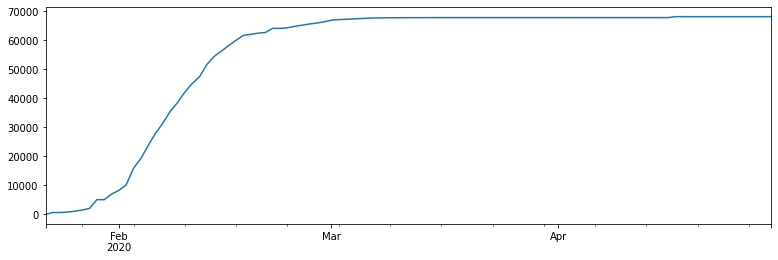

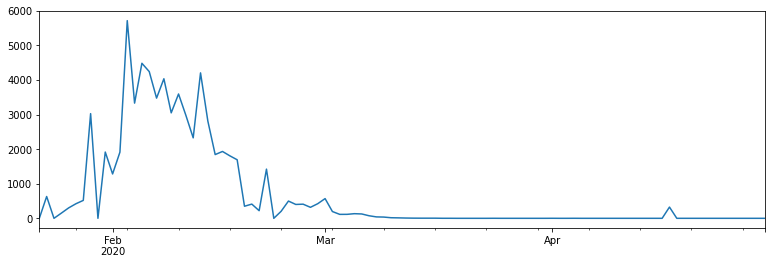

In [ ]:
def fix_hubei_data(sub_data):
    index = np.where(sub_data.index == '2020-02-12')[0][0] + 1
    # Shift data one day to the future
    sub_data.iloc[:index] = np.concatenate([np.zeros([1,]), sub_data.iloc[:index-1].values])

    # Apply parameter to normalize lab tested cases and clinical + lab tested cases
    sub_data.iloc[:index] = sub_data.iloc[:index] * (1 + 15384 / 36602)
    sub_data.iloc[index] = sub_data.iloc[index] * (0.65 + 15384 / 36602)

    return sub_data

# Fix Hubei data
if 'China-Hubei' in sdf.columns:
    sdf['China-Hubei'] = fix_hubei_data(sdf['China-Hubei'])

sdf['China-Hubei'].plot(figsize=(13, 4))
plt.figure()
sdf['China-Hubei'].diff().fillna(0).plot(figsize=(13, 4))

# Normalize by day of first case

In [ ]:
# Normalize data by the day of the first case
date_index = pd.DatetimeIndex(sdf.index)
day_of_first_case = sdf.ne(0).idxmax()
print(day_of_first_case)
shifts = []
for region in sdf.columns:
    shift_index = np.where(sdf.index == day_of_first_case[region])[0][0]
    sdf[region] = sdf[region].shift(-1 * (shift_index-1), fill_value=np.nan) #sdf[region][-1])
    shifts.append(shift_index-1)

sdf.index = np.arange(len(sdf.index))
shifts_df = pd.DataFrame(np.expand_dims(np.array(shifts), 0), columns=sdf.columns)
day_of_first_case

Province/State
Afghanistan          2020-02-24
Albania              2020-03-09
Algeria              2020-02-25
Andorra              2020-03-02
Angola               2020-03-20
                        ...    
West Bank and Gaza   2020-03-05
Western Sahara       2020-04-05
Yemen                2020-04-10
Zambia               2020-03-18
Zimbabwe             2020-03-20
Length: 266, dtype: datetime64[ns]


Province/State
Afghanistan          2020-02-24
Albania              2020-03-09
Algeria              2020-02-25
Andorra              2020-03-02
Angola               2020-03-20
                        ...    
West Bank and Gaza   2020-03-05
Western Sahara       2020-04-05
Yemen                2020-04-10
Zambia               2020-03-18
Zimbabwe             2020-03-20
Length: 266, dtype: datetime64[ns]

### Plot some data

In [ ]:
all_regions = sdf.columns
print ('List of available countries or regions: ' + str(all_regions))
sdf

List of available countries or regions: Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Australia-Australian Capital Territory', 'Australia-New South Wales',
       ...
       'United Kingdom', 'Uruguay', 'Uzbekistan', 'Venezuela', 'Vietnam',
       'West Bank and Gaza', 'Western Sahara', 'Yemen', 'Zambia', 'Zimbabwe'],
      dtype='object', name='Province/State', length=266)


Province/State,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia-Australian Capital Territory,Australia-New South Wales,Australia-Northern Territory,Australia-Queensland,Australia-South Australia,Australia-Tasmania,Australia-Victoria,Australia-Western Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada-Alberta,...,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tajikistan,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom-Anguilla,United Kingdom-Bermuda,United Kingdom-British Virgin Islands,United Kingdom-Cayman Islands,United Kingdom-Channel Islands,United Kingdom-Falkland Islands (Malvinas),United Kingdom-Gibraltar,United Kingdom-Isle of Man,United Kingdom-Montserrat,United Kingdom-Turks and Caicos Islands,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,4.0,1.0,8.0,2.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,4.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,2.0,4.0,1.0,2.0,2.0,4.0,4.0,1.0,2.0,1.0
2,1.0,10.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,4.0,1.0,3.0,2.0,1.0,1.0,2.0,2.0,3.0,1.0,23.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,4.0,1.0,1.0,4.0,2.0,8.0,2.0,3.0,1.0,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,4.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,4.0,2.0,6.0,6.0,10.0,2.0,7.0,4.0,1.0,2.0,3.0
3,1.0,12.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,4.0,0.0,2.0,2.0,1.0,1.0,2.0,3.0,3.0,1.0,33.0,3.0,5.0,1.0,1.0,2.0,2.0,1.0,3.0,3.0,4.0,1.0,11.0,4.0,2.0,10.0,3.0,3.0,1.0,2.0,4.0,...,1.0,1.0,1.0,1.0,1.0,8.0,1.0,3.0,NaN,3.0,5.0,1.0,1.0,4.0,1.0,5.0,2.0,9.0,1.0,4.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,5.0,1.0,5.0,2.0,8.0,10.0,17.0,2.0,16.0,4.0,1.0,2.0,3.0
4,1.0,23.0,1.0,1.0,3.0,1.0,2.0,1.0,2.0,4.0,0.0,3.0,2.0,1.0,1.0,2.0,3.0,3.0,3.0,33.0,3.0,5.0,1.0,1.0,2.0,2.0,1.0,10.0,3.0,4.0,2.0,11.0,7.0,2.0,14.0,3.0,3.0,1.0,2.0,7.0,...,1.0,1.0,1.0,1.0,1.0,8.0,5.0,3.0,NaN,6.0,7.0,1.0,1.0,5.0,1.0,5.0,2.0,9.0,1.0,4.0,2.0,6.0,3.0,1.0,2.0,2.0,1.0,13.0,1.0,5.0,8.0,29.0,15.0,33.0,2.0,16.0,4.0,1.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3016.0,NaN,NaN,NaN,NaN,1361.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122.0,NaN,NaN,...,NaN,663.0,NaN,NaN,NaN,NaN,NaN,429.0,NaN,NaN,2907.0,NaN,NaN,NaN,NaN,NaN,940829.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270.0,NaN,NaN,NaN,NaN,NaN
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3025.0,NaN,NaN,NaN,NaN,1364.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,429.0,NaN,NaN,2922.0,NaN,NaN,NaN,NaN,NaN,968518.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270.0,NaN,NaN,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4

Total number of places (Province/State/Country/Region): 4


Province/State
China-Hubei   2020-01-23
Italy         2020-01-31
Brazil        2020-02-26
dtype: datetime64[ns]

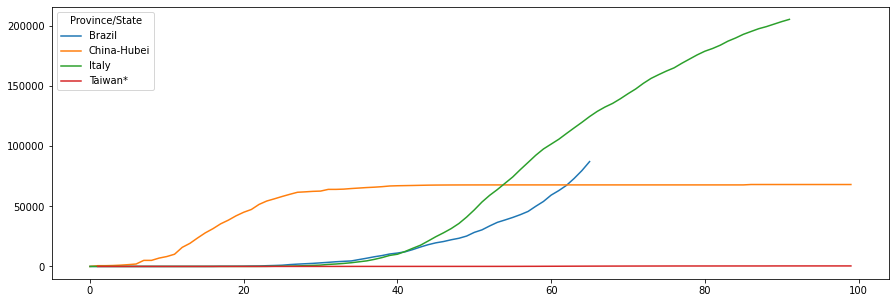

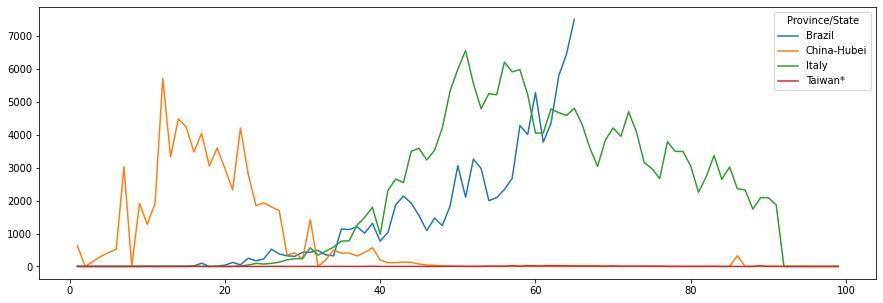

In [ ]:
# Select which countries/regions to use in dataset test
selected_regions = ['China-Hubei', 'Taiwan*', 'Italy', 'Brazil']
rdf = sdf.loc[:, sdf.columns.str.contains(r'|'.join(selected_regions))]

print('Total number of places (Province/State/Country/Region): ' + str(len(rdf.columns)))
rdf.plot(figsize=(15, 5))
rdf.diff().fillna(axis=1, method='ffill').plot(figsize=(15, 5))
day_of_first_case.loc[['China-Hubei', 'Italy', 'Brazil']]

# Data Preprocessing

# Experiment

### Data train

In [ ]:
data = sdf.loc[:, sdf.columns.str.contains(r'|'.join(selected_regions))]
data_train = sdf.loc[:, sdf.columns.str.contains(r'|'.join(['China']))]
data_train = data_train.loc[:, data_train.columns != 'China-Hubei'].fillna(0.0)

#data_train = data_train.diff().fillna(axis=1, method='ffill')
data_train = data_train.dropna()
dataset = data_train.astype('float32')
dataset = dataset.diff().dropna()

dataset = dataset.rolling(14, min_periods=1).mean().values

# Functions

In [ ]:
# split a univariate dataset into train/test sets
def split_dataset(data):
  # split into standard weeks
  print(data.shape)
  train, test = data[1:-28], data[-28:]
  # restructure into windows of weekly data
  train = array(split(train, len(train)/7))
  test = array(split(test, len(test)/7))
  print(train.shape, test.shape)
  return train, test
 
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores
 
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))
 
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=45):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)
 
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 1, 200, 64
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

def build_model_ed_lstm(train, n_input):
	train_x, train_y = to_supervised(train, n_input)
	verbose, epochs, batch_size = 1,200,64
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	#define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	#fit
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose = verbose)
	return model


# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat
 
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores, model, predictions


# Experiment

(99, 32)
(10, 7, 32) (4, 7, 32)
Epoch 1/200
1/1 [==============================] - 0s 2ms/step - loss: 0.2012
Epoch 2/200
1/1 [==============================] - 0s 1ms/step - loss: 0.1965
Epoch 3/200
1/1 [==============================] - 0s 1ms/step - loss: 0.1927
Epoch 4/200
1/1 [==============================] - 0s 1ms/step - loss: 0.1897
Epoch 5/200
1/1 [==============================] - 0s 1ms/step - loss: 0.1867
Epoch 6/200
1/1 [==============================] - 0s 1ms/step - loss: 0.1837
Epoch 7/200
1/1 [==============================] - 0s 1ms/step - loss: 0.1807
Epoch 8/200
1/1 [==============================] - 0s 1ms/step - loss: 0.1776
Epoch 9/200
1/1 [==============================] - 0s 1ms/step - loss: 0.1742
Epoch 10/200
1/1 [==============================] - 0s 1ms/step - loss: 0.1705
Epoch 11/200
1/1 [==============================] - 0s 1ms/step - loss: 0.1664
Epoch 12/200
1/1 [==============================] - 0s 2ms/step - loss: 0.1617
Epoch 13/200
1/1 [===========

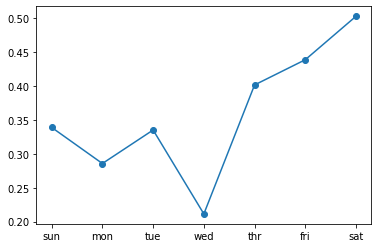

In [ ]:
# Scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(dataset), columns=data_train.columns)

# split into train and test
train, test = split_dataset(df_scaled.values)

# evaluate model and get scores
n_input = 7
score, scores, model, predictions = evaluate_model(train, test, n_input)

# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

In [ ]:
#Brazilian Region Data
state = 'RN'
sdf_rn = pd.read_csv('new_ms_data.csv', delimiter=';')
sdf_rn = sdf_rn.loc[sdf_rn['estado'] == state]
sdf_rn['casosAcumulados'].values.shape
data_test_pd = pd.DataFrame(sdf_rn['casosAcumulados'].values[:65], columns=[state])

#County
country_test = 'Brazil'
#data_test = sdf.loc[:, sdf.columns.str.contains(r'|'.join([country_test]))]

#Scale data
data_test = scaler.fit_transform(data_test_pd.diff().dropna())
data_test__ = data_test[1:]
data_test__ = data_test__.reshape(-1,7,1)
print(data_test__.shape)

#Parameter
n_input = 7
data_test_ = to_supervised(data_test__, n_input, 7)
yhat_sequence = forecast(model, data_test_[0], n_input)

print("Input data test shape: {}".format(data_test_[0].shape))

data_test_reshaped = data_test_[0].reshape(data_test_[0].shape[0],-1)
data_plot = list()

#Append forecast data and real data
for i in range(len(data_test_reshaped[0])):
  data_plot.append(data_test_reshaped[0][i])
print(data_plot)
for i in range(1,data_test_reshaped.shape[0]):
  data_plot.append(data_test_reshaped[i][-1])

dp = concatenate([scaler.inverse_transform(np.array(data_plot).reshape(-1,1)), scaler.inverse_transform(np.array(yhat_sequence).reshape(-1,1))], axis=0)
dp = dp.numpy()

(9, 7, 1)
Input data test shape: (50, 7, 1)
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [ ]:
from datetime import datetime

#Change date column to index column 
first_day = day_of_first_case.loc[[country_test]]
index_date = pd.date_range(first_day.values[0], periods=150).tolist()
dates = pd.to_datetime(index_date, format='%d-%Y-%m')

# Plot

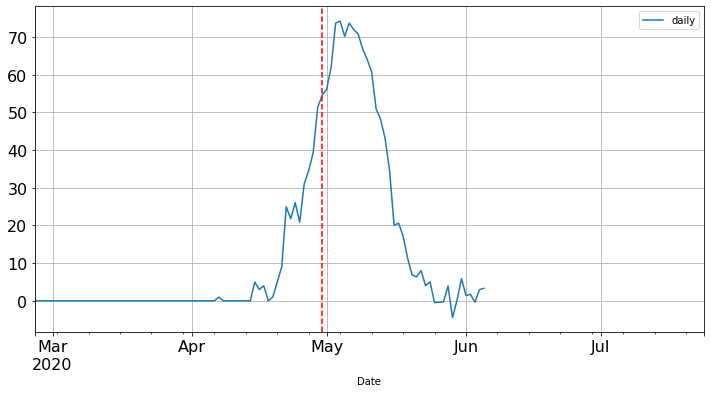

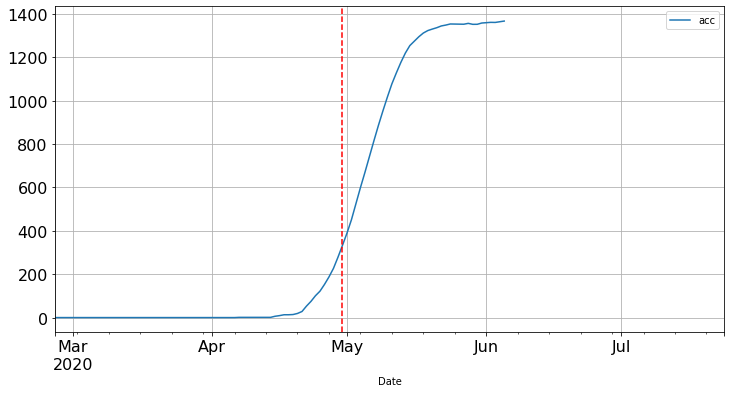

In [ ]:
#Daily
df_plot = pd.concat([pd.DataFrame(dp), pd.DataFrame(dates)], axis=1)
df_plot.columns = ['daily','Date']
df_plot_date = pd.DataFrame(df_plot.values, index = df_plot.index, columns=df_plot.columns)
df_plot_date.set_index('Date',  inplace=True)

df_plot_date.index = pd.to_datetime(df_plot_date.index)

ax = df_plot_date.plot(figsize=(12,6),
                       title='', 
                       fontsize=16, grid=True)
ax.axvline(datetime.strftime(df_plot.iloc[data_test.shape[0]]['Date'],'%D-%Y-%m'), color="red", linestyle="--")

#Accumulate
df_plot = pd.concat([pd.DataFrame(dp).cumsum(), pd.DataFrame(dates)], axis=1)
df_plot.columns = ['acc','Date']
df_plot_date = pd.DataFrame(df_plot.values, index = df_plot.index, columns=df_plot.columns)
df_plot_date.set_index('Date',  inplace=True)

ax = df_plot_date.plot(figsize=(12,6),
                       title='', 
                       fontsize=16, grid=True)
ax.axvline(datetime.strftime(df_plot.iloc[data_test.shape[0]]['Date'],'%D-%Y-%m'), color="red", linestyle="--")